# Pytorch Notebook



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## Pytorch basics
If you are using jupyterlab, enable "show contextual help" for checking the definitions of functions!

In [2]:
# Get variables
x = torch.ones(3, 4)

print(x)
print(x.view(1, 12))
print(x.view(2, -1))

y = torch.rand(3, 4)
z = x + y

print(z.size())
print(z)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
torch.Size([3, 4])
tensor([[1.9885, 1.5953, 1.1248, 1.4521],
        [1.7281, 1.3659, 1.6528, 1.3842],
        [1.1726, 1.2522, 1.9834, 1.5286]])


In [3]:
# Auto grad basics
x = torch.ones(1, 2, requires_grad=True)
print(x)

y = 2 * x + 2
print(y)
print(y.grad_fn)

z = y * y * 3
out = z.mean()
print(z, out)

# , detach

tensor([[1., 1.]], requires_grad=True)
tensor([[4., 4.]], grad_fn=<AddBackward0>)
tensor([[48., 48.]], grad_fn=<MulBackward0>) tensor(48., grad_fn=<MeanBackward0>)


In [4]:
x = torch.randn(2, 2)  # <-- for constants, requires_grad is initially False
x = ((x * 3) / (x - 1))
print(x.requires_grad)

x.requires_grad_(True) # <-- Switch requires_grad by hand
print(x.requires_grad)

y = (x ** 2).sum()
print(y.grad_fn)

False
True


### backward

In [5]:
x = torch.ones(2, 2, requires_grad=True) # <-- enable grad calculation
print(x)
print(x.requires_grad)
print(x.grad_fn)
print("---")

y = x + 2
print(y)
print(y.requires_grad)
print(y.grad_fn)
print("---")

z = y * y * 3
out = z.mean()
print(z, out)
print(z.requires_grad, out.requires_grad)
print(z.grad_fn, out.grad_fn)
print("---")

out.backward() # <-- run backprop
print(x.grad)

# running backward() multiple times elicit an error
#out.backward() # <-- run backprop
#print(x.grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
True
None
---
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
True
---
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
True True
<MulBackward0 object at 0x12dbbeb00> <MeanBackward0 object at 0x12dbbebe0>
---
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### vector-Jacobian product
This characteristic of vector-Jacobian product makes it very convenient to feed external gradients into a model that has non-scalar output.

Now in this case y is no longer a scalar. torch.autograd could not compute the full Jacobian directly, but if we just want the vector-Jacobian product, simply pass the vector to backward as argument. $J$ is jacobian. and ${\rm x\_grad} = J^\top v$. If the backward target is a scalar function, $v = (\frac{l}{y_1}, \cdots, \frac{l}{y_m})^\top$

In [6]:
x = torch.ones(3, requires_grad=True)
y = x * 2

print(f"norm : {y.data.norm()}")
print(y)
while y.data.norm() < 1000:
    y = y * 2
    print(f"norm : {y.data.norm()}")
    print(y)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)
print(x.grad)

norm : 3.464101552963257
tensor([2., 2., 2.], grad_fn=<MulBackward0>)
norm : 6.928203105926514
tensor([4., 4., 4.], grad_fn=<MulBackward0>)
norm : 13.856406211853027
tensor([8., 8., 8.], grad_fn=<MulBackward0>)
norm : 27.712812423706055
tensor([16., 16., 16.], grad_fn=<MulBackward0>)
norm : 55.42562484741211
tensor([32., 32., 32.], grad_fn=<MulBackward0>)
norm : 110.85124969482422
tensor([64., 64., 64.], grad_fn=<MulBackward0>)
norm : 221.70249938964844
tensor([128., 128., 128.], grad_fn=<MulBackward0>)
norm : 443.4049987792969
tensor([256., 256., 256.], grad_fn=<MulBackward0>)
norm : 886.8099975585938
tensor([512., 512., 512.], grad_fn=<MulBackward0>)
norm : 1773.6199951171875
tensor([1024., 1024., 1024.], grad_fn=<MulBackward0>)
tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


### Stop autograd by wrapping with no_grad

In [7]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
print((x ** 2).requires_grad)

# stop autograd and block 
with torch.no_grad():
    print((x ** 2).requires_grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
True
False


### Use detach() to get a "new" Tensor with the same content but that does not require gradient

In [8]:
x = torch.tensor([2], dtype=torch.float, requires_grad=True)
y = torch.tensor([3], dtype=torch.float, requires_grad=True)

out = (x ** 2) * (y ** 2)
print(out.requires_grad)
z = out.detach()
print(z.requires_grad)

# z.backward() # <-- return an error

True
False


## Autograd and some specific topics

### Define Fully Connected Feed Forward NN $f_{\theta}$ 

In [11]:
class FFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self):
        super(FFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=10)
        self.fc3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        out = self.fc3(h)
        return out

ffnet = FFNetwork()
print(ffnet)

params = list(ffnet.parameters())
#print(params)
print(f"num_params : {len(params)}")
for i in range(len(params)):
    print(params[i].size())
print("---")

# Trial input
input = torch.randn(3, 1)
print(input)
out = ffnet(input)
print(out)

FFNetwork(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
num_params : 6
torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])
---
tensor([[ 0.2376],
        [-1.1409],
        [ 0.8915]])
tensor([[0.2895],
        [0.2810],
        [0.2778]], grad_fn=<AddmmBackward>)


### Calculate Loss $L(\theta)$

In [14]:
input = torch.randn(10, 1)
target = torch.ones(10, 1, requires_grad=False)

# Mean squared error of the minibatch with 10 samples
loss_func = nn.MSELoss()

out = ffnet(input)
loss = loss_func(out, target)
print(loss)

tensor(0.5083, grad_fn=<MseLossBackward>)


### Calculate $\nabla_\theta L(\theta, x)|_{x=x_0}$

In [15]:
input = torch.randn(10, 1)
target = torch.ones(10, 1, requires_grad=False)

out = ffnet(input)
loss = loss_func(out, target)

ffnet.zero_grad()
print("ffnet.fc1.[param].grad before backward")
print(ffnet.fc1.bias.grad)
print(ffnet.fc1.weight.grad)
print("---")

loss.backward()
print("ffnet.fc1.[param].grad after backward")
print(ffnet.fc1.bias.grad)
print(ffnet.fc1.weight.grad)

ffnet.fc1.[param].grad before backward
None
None
---
ffnet.fc1.[param].grad after backward
tensor([-0.1839, -0.0010,  0.0364, -0.0009,  0.0036,  0.0254, -0.0179, -0.1829,
         0.0325,  0.0012])
tensor([[ 0.0912],
        [ 0.0004],
        [-0.0121],
        [ 0.0003],
        [-0.0041],
        [-0.0029],
        [ 0.0164],
        [ 0.0681],
        [-0.0307],
        [-0.0004]])


### Update $\theta \leftarrow \theta + \alpha \nabla_\theta L(\theta, x)|_{x=x_0}$

#### Individual parameter update

tensor([[0.6371],
        [0.7066],
        [1.1070],
        [0.7094],
        [1.1457],
        [1.1943],
        [1.0245],
        [0.7151],
        [0.5852],
        [0.8385]])


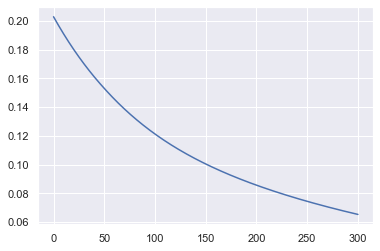

In [129]:
ffnet = FFNetwork()
learning_rate = 0.001

out = ffnet(input)
loss = loss_func(out, target)

loss_hist_sgd = [loss.detach()]
for i in range(300):
    ffnet.zero_grad()
    loss.backward()
    for f in ffnet.parameters():
        f.data.sub_(f.grad.data * learning_rate)
        
    loss = loss_func(ffnet(input), target)
    loss_hist_sgd.append(loss.detach())

plt.plot(loss_hist_sgd)
out = ffnet(input)
print(out.detach())

#### Update by using Optimizer

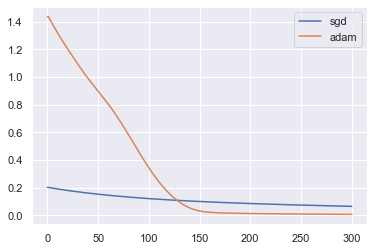

In [130]:
ffnet = FFNetwork()
learning_rate = 0.01

optimizer = optim.Adam(ffnet.parameters(), lr=0.001)

loss = loss_func(ffnet(input), target)
loss_hist_adam = [loss.detach()]

for i in range(300):
    optimizer.zero_grad()
    loss = loss_func(ffnet(input), target)
    loss_hist_adam.append(loss.detach())
    loss.backward()
    optimizer.step()

plt.plot(loss_hist_sgd, label="sgd")
plt.plot(loss_hist_adam, label="adam")
plt.legend(loc="best")

### Update weight by minibatch $\frac{1}{N} \sum_{n=1}^N \nabla_\theta L(\theta, x)|_{x=x_n}$

### Calculate $\nabla_x L(\theta, x)|_{x=x_0}$

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$

### Copy $\theta_1$ to $\theta_2$

### Copy $\theta_1$ to $\theta_2$ and update only $\theta_1$ by $\theta \leftarrow \theta + \alpha \nabla_\theta L(\theta, x)|_{x=x_0}$

### Stochastic sampling from $f_\theta(x)$

### Inject noise (reparametrization trick) and cal grad $\nabla_\theta f_\theta(x, \epsilon)$, $\epsilon\sim {\cal N}(\mu, \sigma^2)$

### Use weighted update $\theta \leftarrow \theta + \alpha \delta \nabla_\theta L(\theta, x)|_{x=x_0}$, $\delta  = f_\theta(x) - \theta_0$

### Use noisy weight $f(x, \theta + \epsilon)$, $\epsilon \sim {\cal N}(1, 0)$

### Update $\theta$ by the approximated variational method

# Convolution Neural Networks

### Define CNN $f_\theta(x)$

### Update weight by minibatch for CNN

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$ for CNN

# Recurrent Neural Networks

### Define RNN $f_\theta(x_0, x_1, \dots, x_T)$

### Update weight by minibatch for RNN

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$ for RNN